In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils

# Common imports

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
human_formatter = ticker.FuncFormatter(utils.human_format)

In [2]:
# get_dataset_df(weekNumber, datasetFileName)
data_all_cats = utils.get_dataset_df(3, "all_categories").drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1", "Trade Flow Code", "Commodity", "Reporter", "Reporter Code", "Partner", "Partner Code", 'Category Code', 'Category', 'Development Category',
       'Development Level', 'Population in 2005 (in million)',
       'Population in 2010 (in million)', 'Population in 2014 (in million)',
       'Population in 2018 (in million)',
       '% Malnutritioned Childern < 5 years old', 'Total Imports in $',
       'Income Index Rank', 'ii2005', 'ii2006', 'ii2007', 'ii2008', 'ii2009',
       'ii2010', 'ii2011', 'ii2012', 'ii2013', 'ii2014', 'ii2015', 'ii2016',
       'ii2017', 'ii2018'])
data_cats_description = utils.get_dataset_df(3, "category_description")
data_countries_description = utils.get_dataset_df(3, "country_description") \
    .drop(columns=['Income Index Rank', 'ii2005', 'ii2006', 'ii2007', 'ii2008', 'ii2009',
       'ii2010', 'ii2011', 'ii2012', 'ii2013', 'ii2014', 'ii2015', 'ii2016',
       'ii2017', 'ii2018', "Total Imports in $"])
data_countries_description = pd.wide_to_long(data_countries_description, stubnames="Population in ", j="Year", suffix=".*", i=['Reporter Code', 'Reporter', 'Reporter ISO', 'Development Category','Development Level', '% Malnutritioned Childern < 5 years old']) \
    .reset_index() \
    .rename(columns={"Population in ": "Population"})
data_countries_description["Year"] = data_countries_description["Year"] \
    .replace(to_replace=" \(in million\)", value="", regex=True)
data_countries_description["Year"] = pd.to_datetime(data_countries_description["Year"], format="%Y")
data_countries_description["Population"] = data_countries_description["Population"] \
    .apply(lambda x: x * 1e6)
data_updated_income = utils.get_dataset_df(3, "updated_income")
data_updated_income = pd.wide_to_long(data_updated_income, stubnames="", j="Year", suffix="\d+", i=["HDI Rank (2018)", "Country"]) \
    .reset_index()
data_updated_income = utils.abbreviate_countries(data_updated_income, "Country")
data_updated_income.columns = [*data_updated_income.columns[:-1], 'Index']
data_updated_income[data_updated_income["Index"] == ".."] = pd.NA
data_updated_income[data_updated_income["HDI Rank (2018)"].isin(["..", ' '])] = pd.NA
data_updated_income["HDI Rank (2018)"] = data_updated_income["HDI Rank (2018)"].dropna().astype(int)
# data_updated_income["Index"] = data_updated_income["Index"].astype(float)
# data_all_cats
# data_cats_description
# data_countries_description
# data_updated_income["Index"].unique()

Good! Now that we have our data setup, it's time to start using it.
First of all, we will plot easy stuff, such as the population change of all the countries that we have.

In [3]:
countries = data_countries_description["Reporter ISO"].unique()
countries

array(['DEU', 'USA', 'JPN', 'KOR', 'HKG', 'MEX', 'CHN', 'BRA', 'THA',
       'TUR', 'IND', 'PAK', 'VNM', 'NGA', 'EGY'], dtype=object)

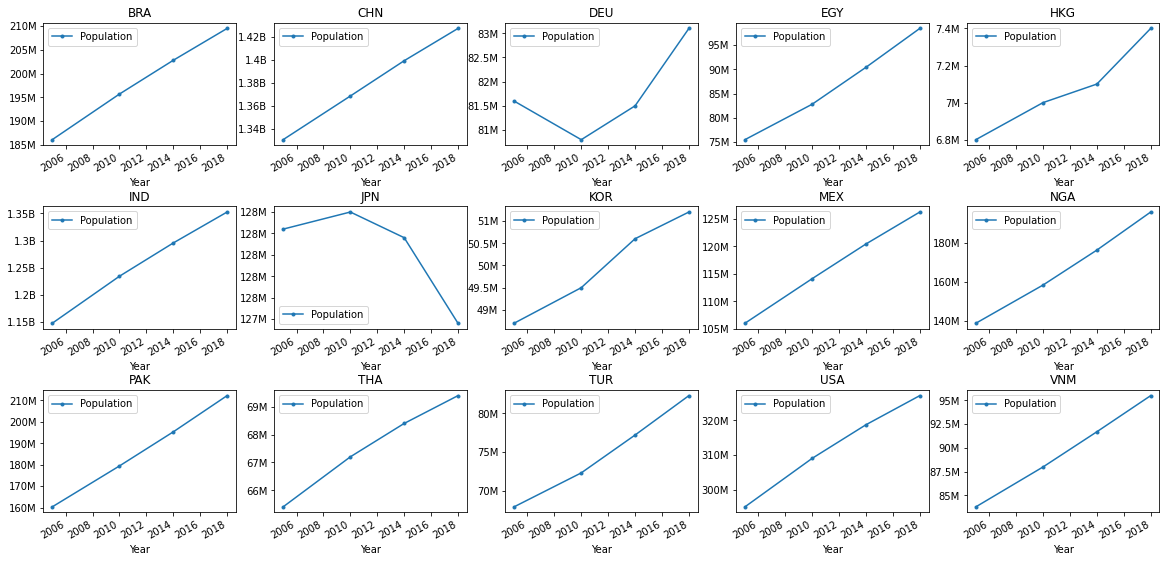

In [4]:
def plot_countries_population(df):
    fig, axes = plt.subplots(3, 5, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5);
    zipped = zip(df.groupby(["Reporter ISO"]), axes.flatten());
    for (country, group), ax in zipped:
        ax.yaxis.set_major_formatter(human_formatter);
        group.plot(kind="line", x='Year', y='Population', ax=ax, title=country, style=".-");

plot_countries_population(data_countries_description)


How do those countries fare in terms of economic index?

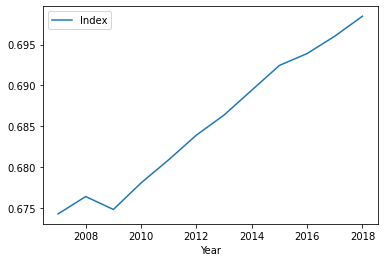

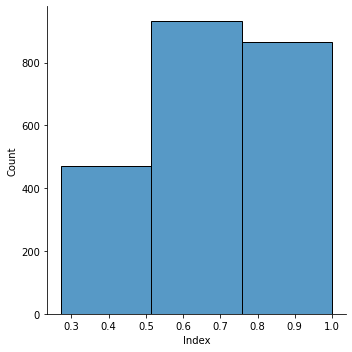

In [5]:
data_updated_income_fixed = data_updated_income.copy()
data_updated_income_fixed["Index"] = data_updated_income_fixed["Index"].dropna().astype(float)
data_updated_income_fixed = data_updated_income_fixed[["Country", "Year", "Index"]]
data_updated_income_fixed.groupby("Year").mean().plot();
sns.displot(data=data_updated_income_fixed, x="Index", bins=3);
# data_updated_income_fixed.hist(by="Country", bins=25, title="Frequency of income index for every country");

On average, who are the top 5 and worst 5 countries in terms of economic index?

In [6]:
tmp_updated_income = data_updated_income_fixed.groupby("Country").mean()
lowest_5_index = tmp_updated_income.nlargest(5, "Index").reset_index()
highest_5_index = tmp_updated_income.nsmallest(5, "Index").reset_index()
lowest_5_index
highest_5_index
del tmp_updated_income

Country     Index
0     BRN  1.000000
1     QAT  1.000000
2     LIE  0.999167
3     KWT  0.999083
4     SGP  0.993333

Country     Index
0     COD  0.290833
1     BDI  0.297500
2     CAF  0.320250
3     NER  0.321833
4     MOZ  0.348417

The best countries in terms of economic index in this dataset turns out to be:
- Brunei
- Qatar
- Liectenstein
- Kuwait
- Singapore

The worst:
- Congo
- Burundi
- Central African Republic
- Niger
- Mozambique

Let's see how these countries evolve their eating habits...
However, we don't have data for these countries on `data_all_cats`, so we will have to see what income index do these countries have.

array(['DEU', 'HKG', 'JPN', 'KOR', 'USA', 'BRA', 'CHN', 'MEX', 'THA',
       'TUR', 'EGY', 'IND', 'NGA', 'PAK', 'VNM'], dtype=object)

array(['BRA', 'CHN', 'EGY', 'DEU', 'HKG', 'IND', 'JPN', 'KOR', 'MEX',
       'NGA', 'PAK', 'THA', 'TUR', 'USA', 'VNM'], dtype=object)

array([], dtype=object)

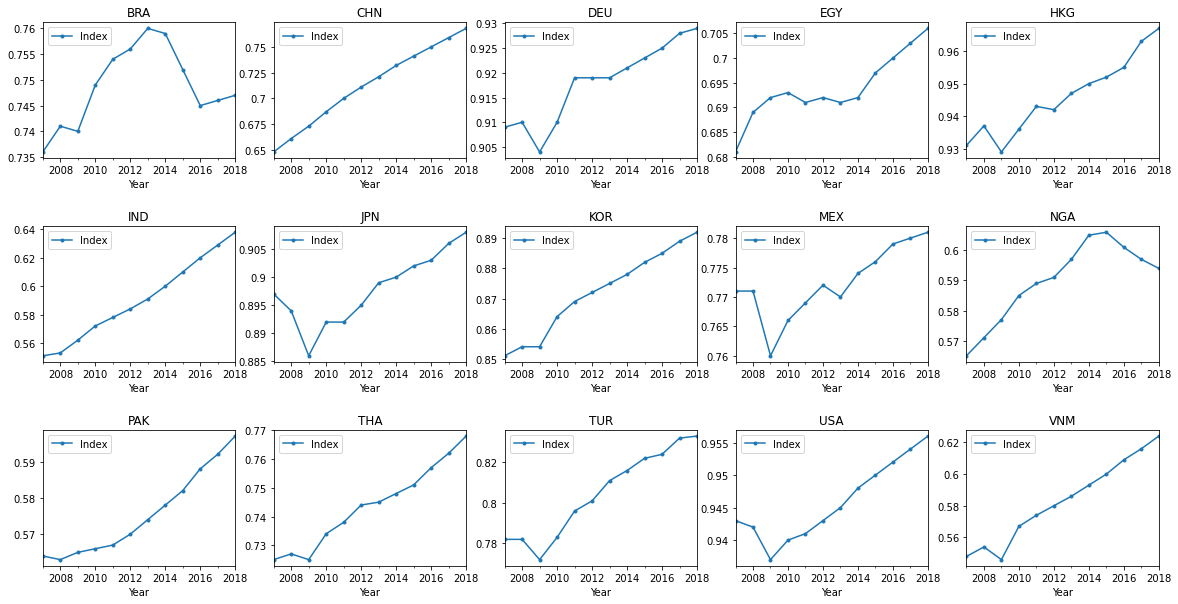

In [7]:
available_countries = data_all_cats["Reporter ISO"].unique()
available_countries
data_income_countries_filtered = data_updated_income_fixed[data_updated_income_fixed["Country"].isin(available_countries)]
data_income_countries_filtered["Year"] = pd.to_datetime(data_income_countries_filtered["Year"], format="%Y")
data_income_countries_filtered["Country"].unique()
np.setdiff1d(available_countries, data_income_countries_filtered["Country"].unique())

def plot_cuntries_income_index(df):
    fig, axes = plt.subplots(3, 5, figsize=(20, 10));
    plt.subplots_adjust(hspace=0.5);
    zipped = zip(df, axes.flatten());
    for (country, group), ax in zipped:
        ax.yaxis.set_major_formatter(human_formatter);
        group.plot(kind="line", x='Year', y='Index', ax=ax, title=country, style=".-");

plot_cuntries_income_index(data_income_countries_filtered.groupby(["Country"]))



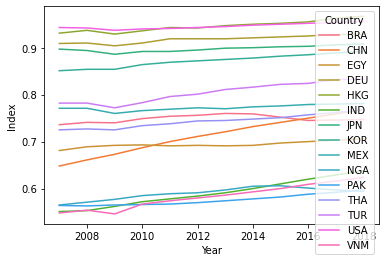

In [8]:
sns.lineplot(data=data_income_countries_filtered, x="Year", y="Index", hue="Country");

In [9]:
data_all_cats.columns
data_all_cats["Commodity Code"].unique()

Index(['Classification', 'Year', 'Trade Flow', 'Reporter ISO', 'Partner ISO',
       'Commodity Code', 'Qty Unit Code', 'Qty Unit', 'Qty', 'Netweight (kg)',
       'Trade Value (US$)'],
      dtype='object')

array([     7,     14,   1509,   1507,   1508,   1510,   1512,   1511,
         1513,     20,   1514,    102,    103,    104,    105,      2,
            3,    407,    408,   1501,   1502,   1504,     16,   2102,
       210610,     10,     11,     17,     18,     19,   2103,     22,
            9,   2104,    402,    401,    403,    405,    406,    409,
          404,   2105])

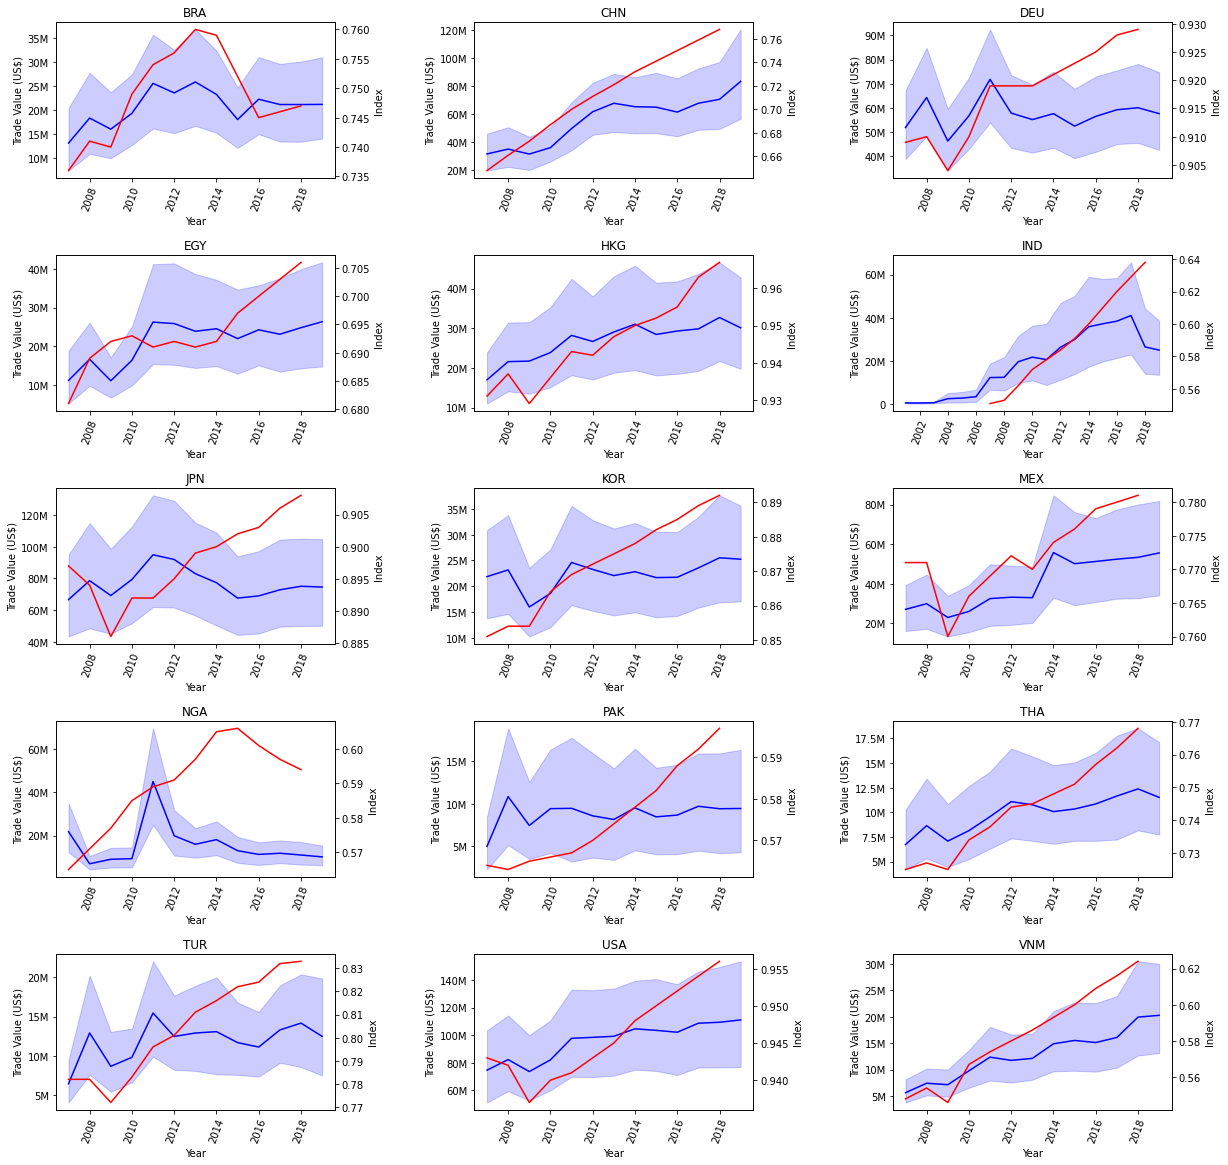

In [10]:
data_all_cats_filtered = data_all_cats[data_all_cats["Reporter ISO"].isin(available_countries)]
data_all_cats_filtered["Year"] = pd.to_datetime(data_all_cats_filtered["Year"], format="%Y")
def plot_income_index_against_trade(df_trades, df_income):
    fig, axes = plt.subplots(5, 3, figsize=(20, 20));
    plt.subplots_adjust(hspace=0.5, wspace=0.5);
    zipped = zip(df_trades, axes.flatten());

    for (country, group), ax in zipped:
        ax.yaxis.set_major_formatter(human_formatter);
        ax.tick_params(axis='x', rotation=70)
        sns.lineplot(data=group[group["Trade Flow"] == "Import"], x="Year", y="Trade Value (US$)", ax=ax, color="blue").set_title(country);
        ax2 = ax.twinx()
        sns.lineplot(data=df_income[df_income["Country"] == country], x="Year", y="Index", ax=ax2, color="r");

plot_income_index_against_trade(data_all_cats_filtered.groupby(["Reporter ISO"]), data_income_countries_filtered)



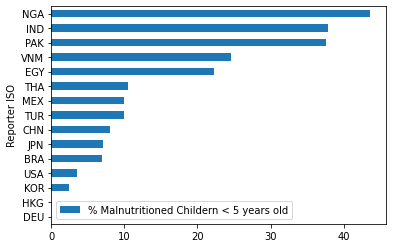

In [11]:
data_countries_description[["Reporter ISO", "% Malnutritioned Childern < 5 years old"]].drop_duplicates() \
    .sort_values(by="% Malnutritioned Childern < 5 years old") \
    .plot(kind="barh", x="Reporter ISO");

Hmm, generally, huge spikes in trade values are also connected to Income Index, but how about specific foods?

Let's compare USA and Nigeria

In [12]:
def draw_commodities_for_reporter(reporter_iso):
    country_commodities = data_all_cats_filtered[data_all_cats_filtered["Reporter ISO"] == reporter_iso][data_all_cats_filtered["Trade Flow"] == "Import"]

    fig, axes = plt.subplots(5, 3, figsize=(20, 20));
    plt.subplots_adjust(hspace=0.5, wspace=0.5);
    zipped = zip(country_commodities.groupby("Commodity Code"), axes.flatten());

    for (commodity, group), ax in zipped:
        commodity_name = data_cats_description[data_cats_description["Commodity Code"] == commodity]["Commodity"].iloc[0]
        ax.yaxis.set_major_formatter(human_formatter);
        ax.tick_params(axis='x', rotation=70)
        sns.lineplot(data=group, x="Year", y="Trade Value (US$)", ax=ax, color="blue").set_title(commodity_name);
        ax2 = ax.twinx()
        # malnutrition_line = data_countries_description[data_countries_description["Reporter"] == reporter_iso]["% Malnutritioned Childern < 5 years old"].iloc[0] / 100.0
        # ax2.axhline(malnutrition_line, ls="--");

        sns.lineplot(data=data_income_countries_filtered[data_income_countries_filtered["Country"] == reporter_iso], x="Year", y="Index", ax=ax2, color="r");


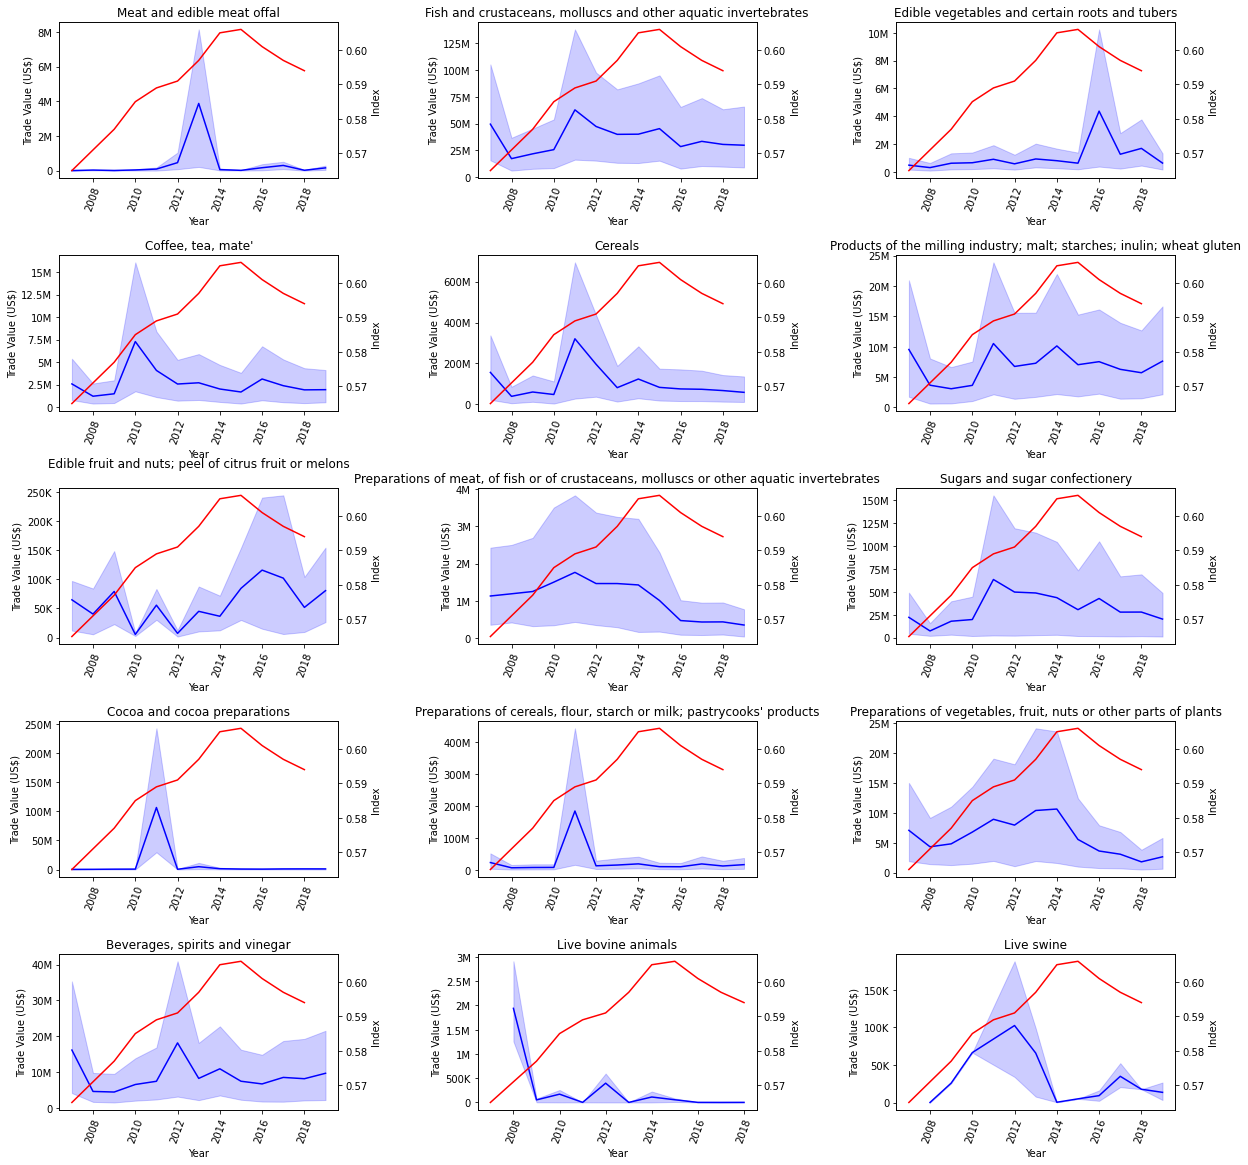

In [13]:
draw_commodities_for_reporter("NGA")

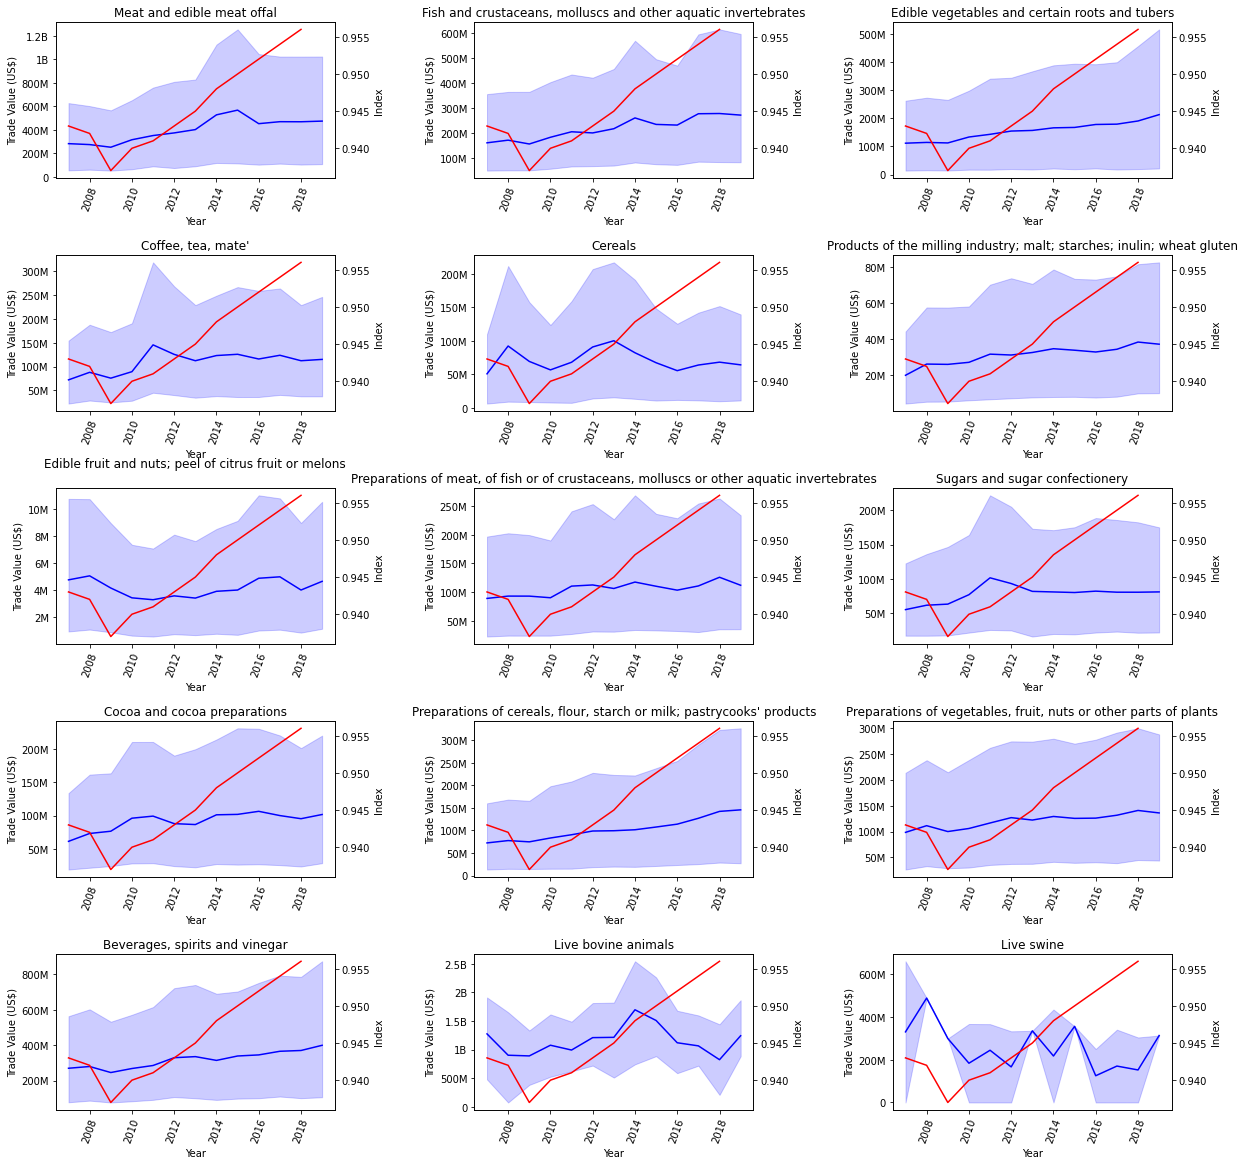

In [14]:
draw_commodities_for_reporter("USA")


In [15]:
def draw_commodities_population_for_reporter(reporter_iso):
    country_commodities = data_all_cats_filtered[data_all_cats_filtered["Reporter ISO"] == reporter_iso][data_all_cats_filtered["Trade Flow"] == "Import"]

    fig, axes = plt.subplots(5, 3, figsize=(20, 20));
    plt.subplots_adjust(hspace=0.5, wspace=0.5);
    zipped = zip(country_commodities.groupby("Commodity Code"), axes.flatten());

    for (commodity, group), ax in zipped:
        commodity_name = data_cats_description[data_cats_description["Commodity Code"] == commodity]["Commodity"].iloc[0]
        ax.yaxis.set_major_formatter(human_formatter);
        ax.tick_params(axis='x', rotation=70)
        sns.lineplot(data=group, x="Year", y="Trade Value (US$)", ax=ax, color="blue").set_title(commodity_name);
        ax2 = ax.twinx()
        # malnutrition_line = data_countries_description[data_countries_description["Reporter"] == reporter_iso]["% Malnutritioned Childern < 5 years old"].iloc[0] / 100.0
        # ax2.axhline(malnutrition_line, ls="--");
        ax2.yaxis.set_major_formatter(human_formatter);
        sns.lineplot(data=data_countries_description[data_countries_description["Reporter ISO"] == reporter_iso], x="Year", y="Population", ax=ax2, color="r");


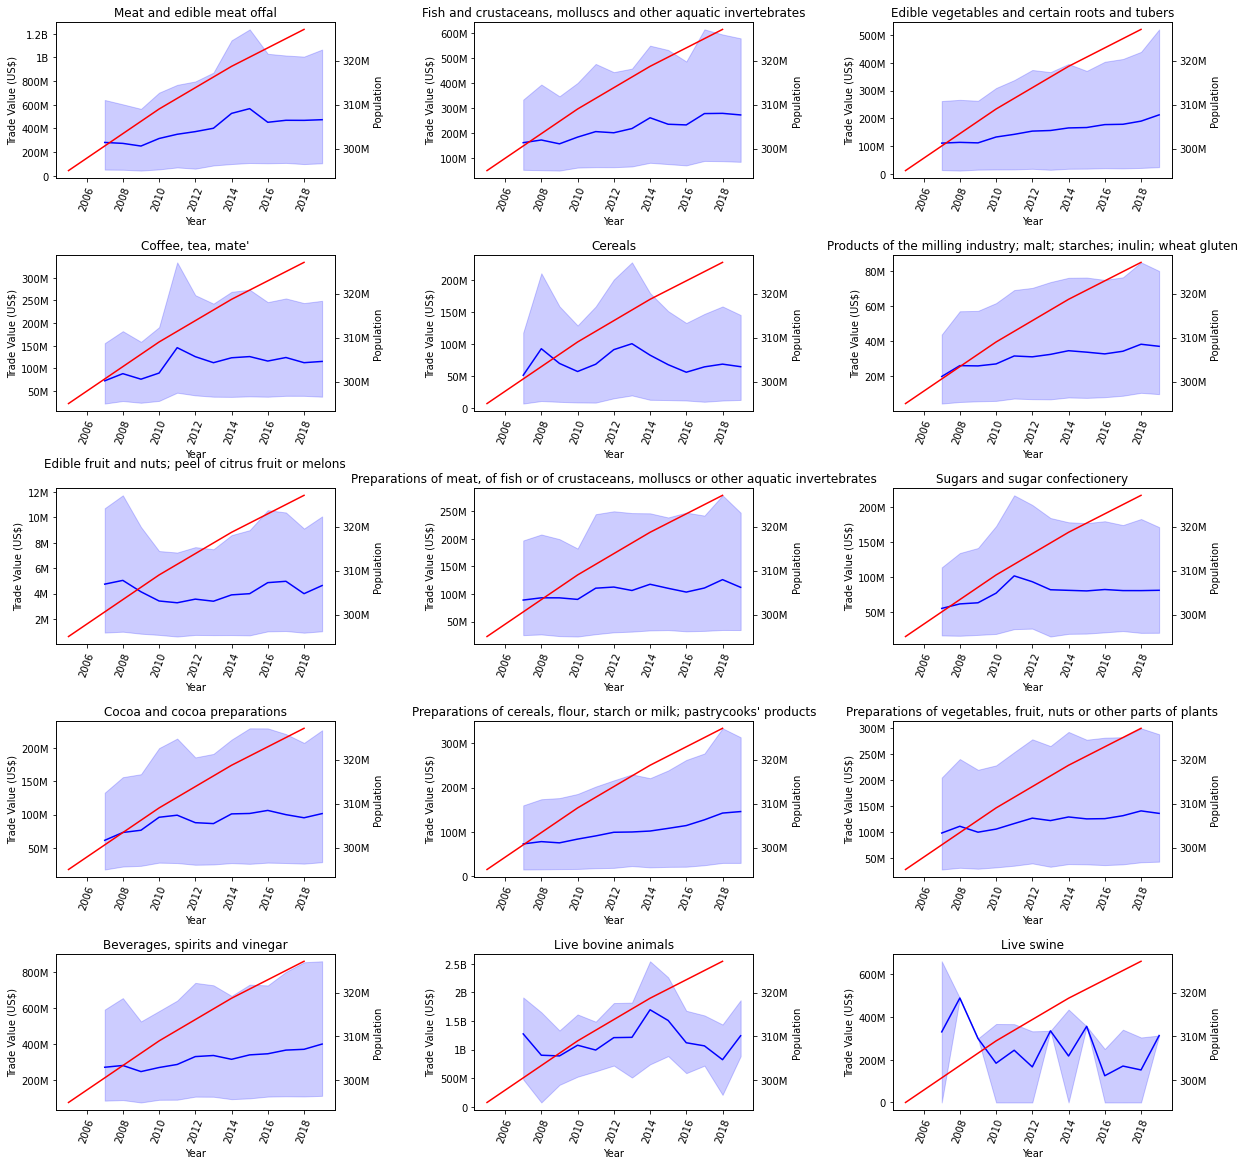

In [16]:
draw_commodities_population_for_reporter("USA")

Let's compare different trade flows between high malnutrition rate, to possibly spot patterns

In [18]:
def plot_compare_commodities_reporters(reporter1_iso, reporter2_iso):
    country_commodities = data_all_cats_filtered[data_all_cats_filtered["Reporter ISO"].isin([reporter1_iso, reporter2_iso])][data_all_cats_filtered["Trade Flow"] == "Import"]
    fig, axes = plt.subplots(7, 3, figsize=(30, 40));
    plt.subplots_adjust(hspace=0.5, wspace=0.3);
    zipped = zip(country_commodities.groupby("Commodity Code"), axes.flatten());

    for (commodity, group), ax in zipped:
        commodity_name = data_cats_description[data_cats_description["Commodity Code"] == commodity]["Commodity"].iloc[0][:40]
        ax.yaxis.set_major_formatter(human_formatter);
        sns.lineplot(data=group[group["Reporter ISO"] == reporter1_iso], x="Year", y="Trade Value (US$)", ax=ax, color="blue").set_title(commodity_name);
        ax.tick_params(axis='x', rotation=70)
        ax2 = ax.twinx()
        ax2.yaxis.set_major_formatter(human_formatter);
        sns.lineplot(data=group[group["Reporter ISO"] == reporter2_iso], x="Year", y="Trade Value (US$)", ax=ax2, color="orange", dashes=True);

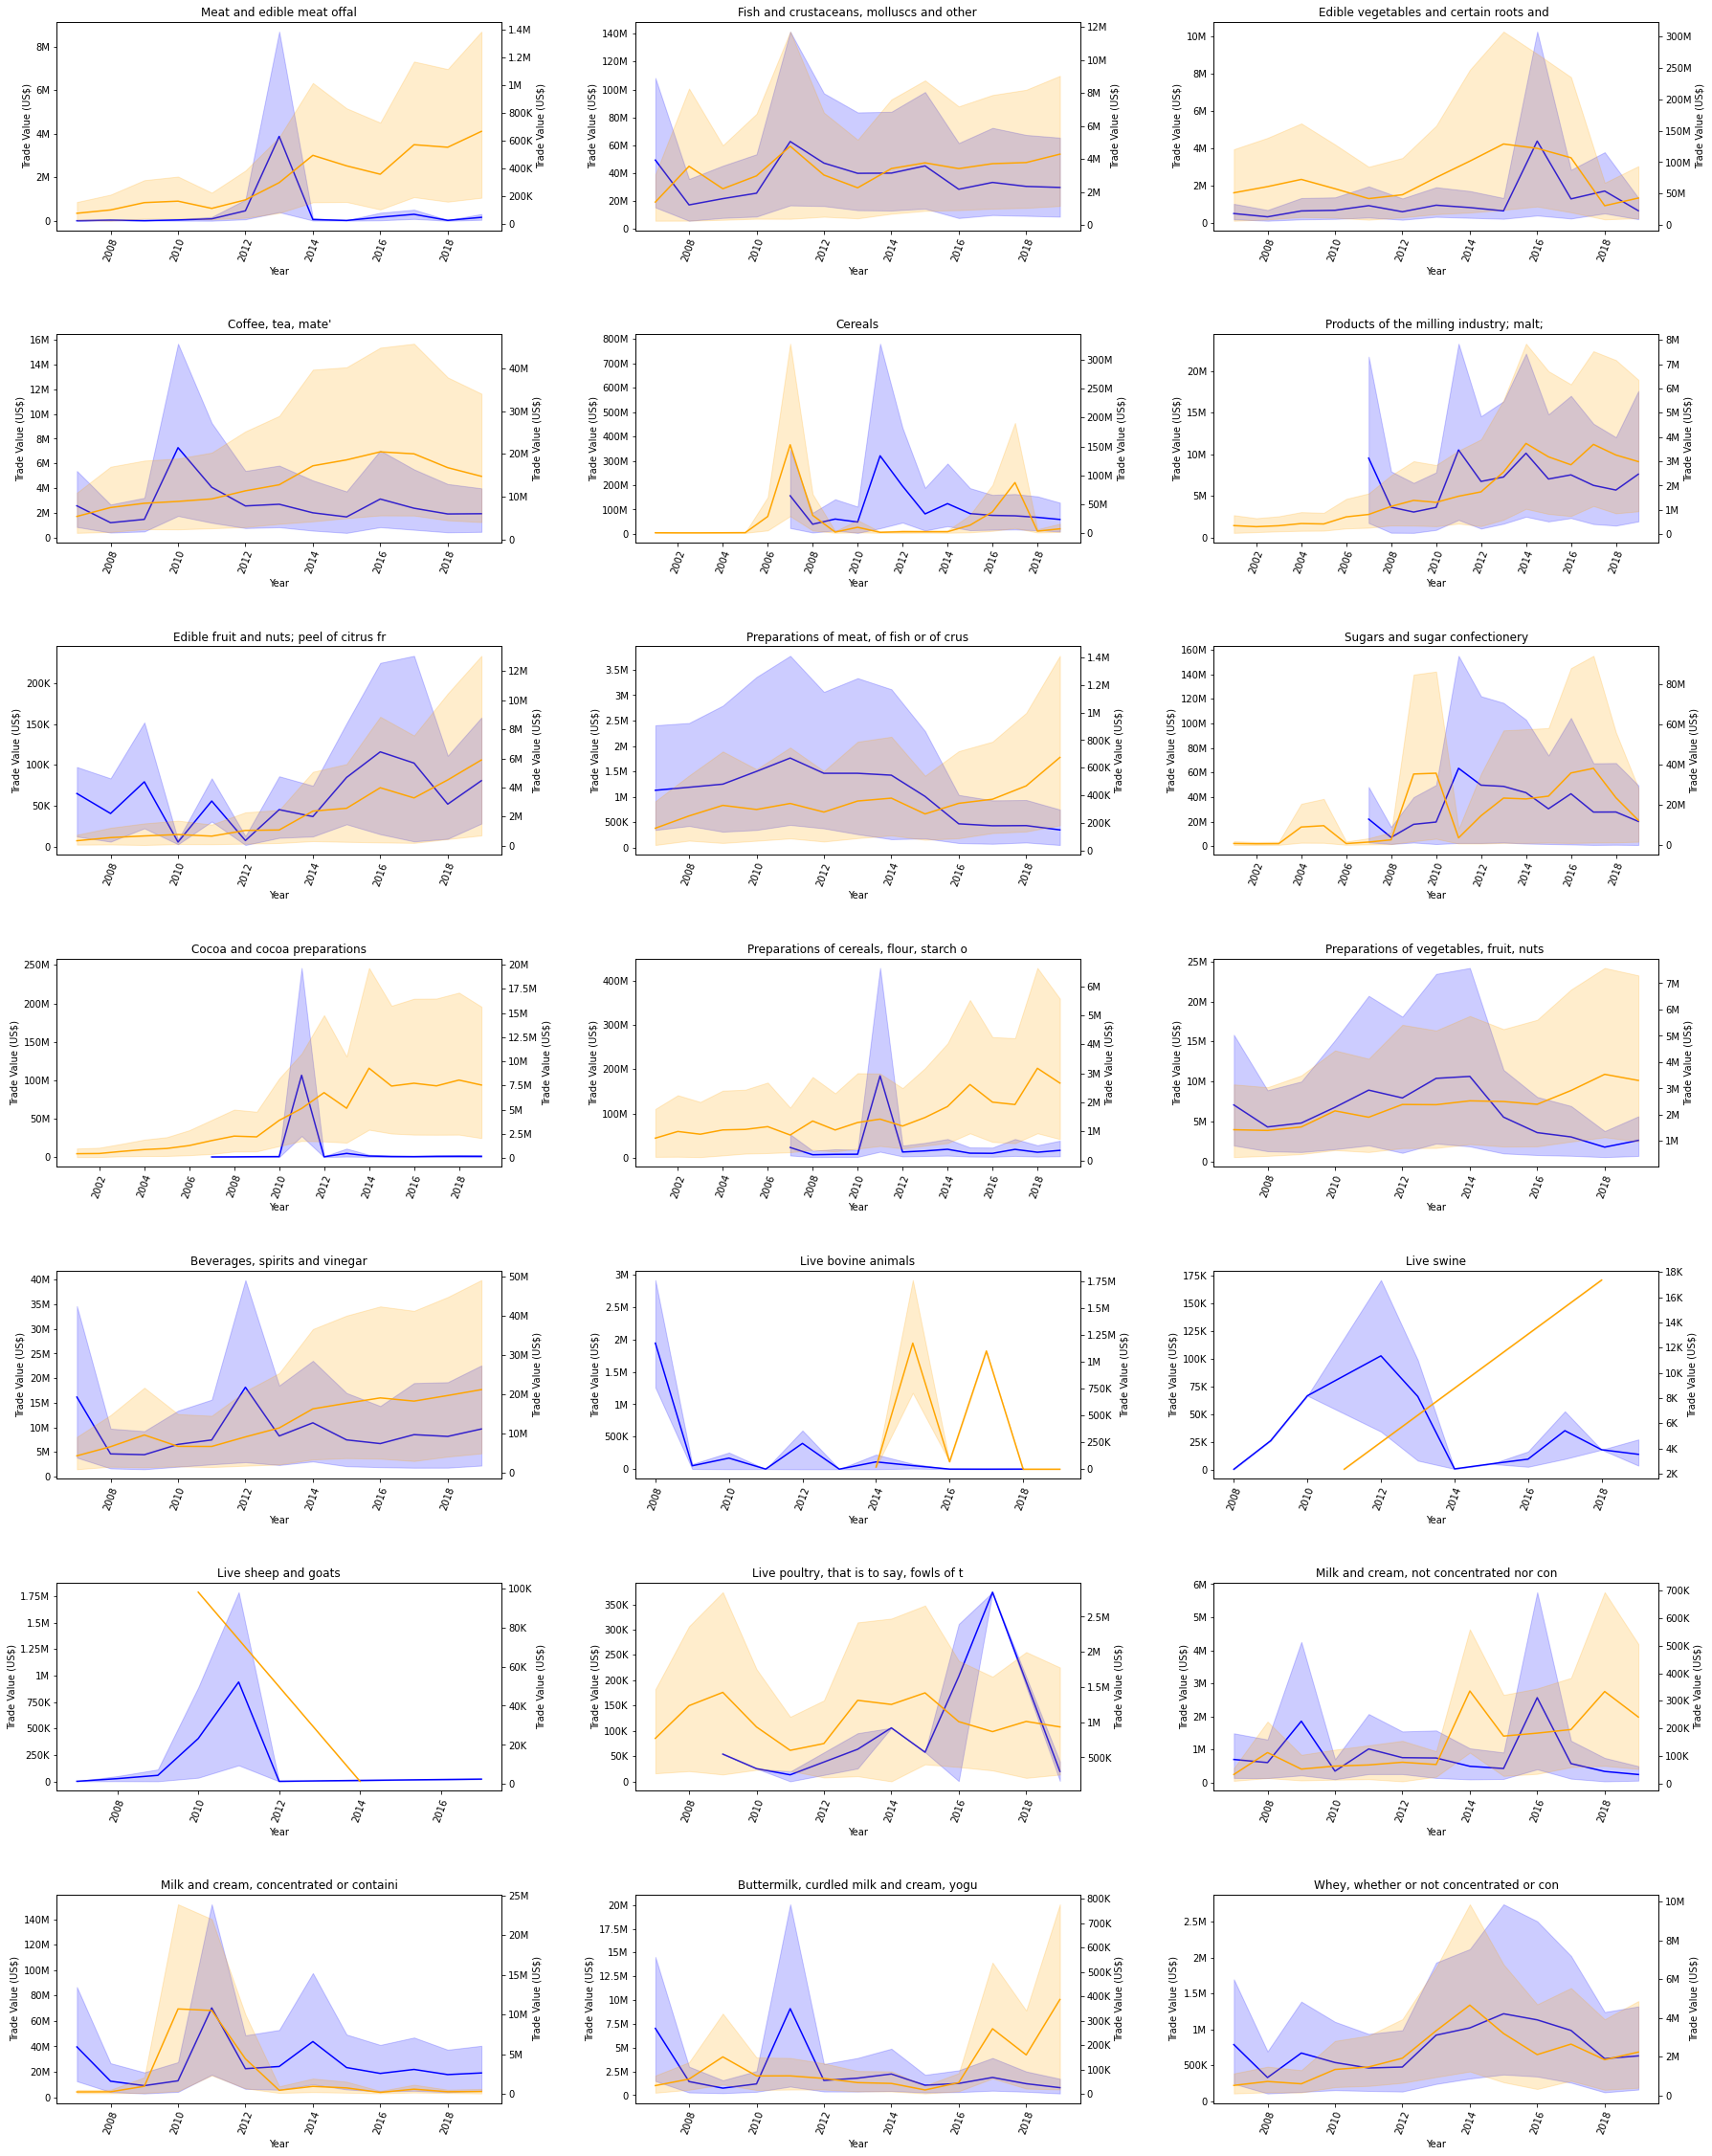

In [19]:
plot_compare_commodities_reporters("NGA", "IND")

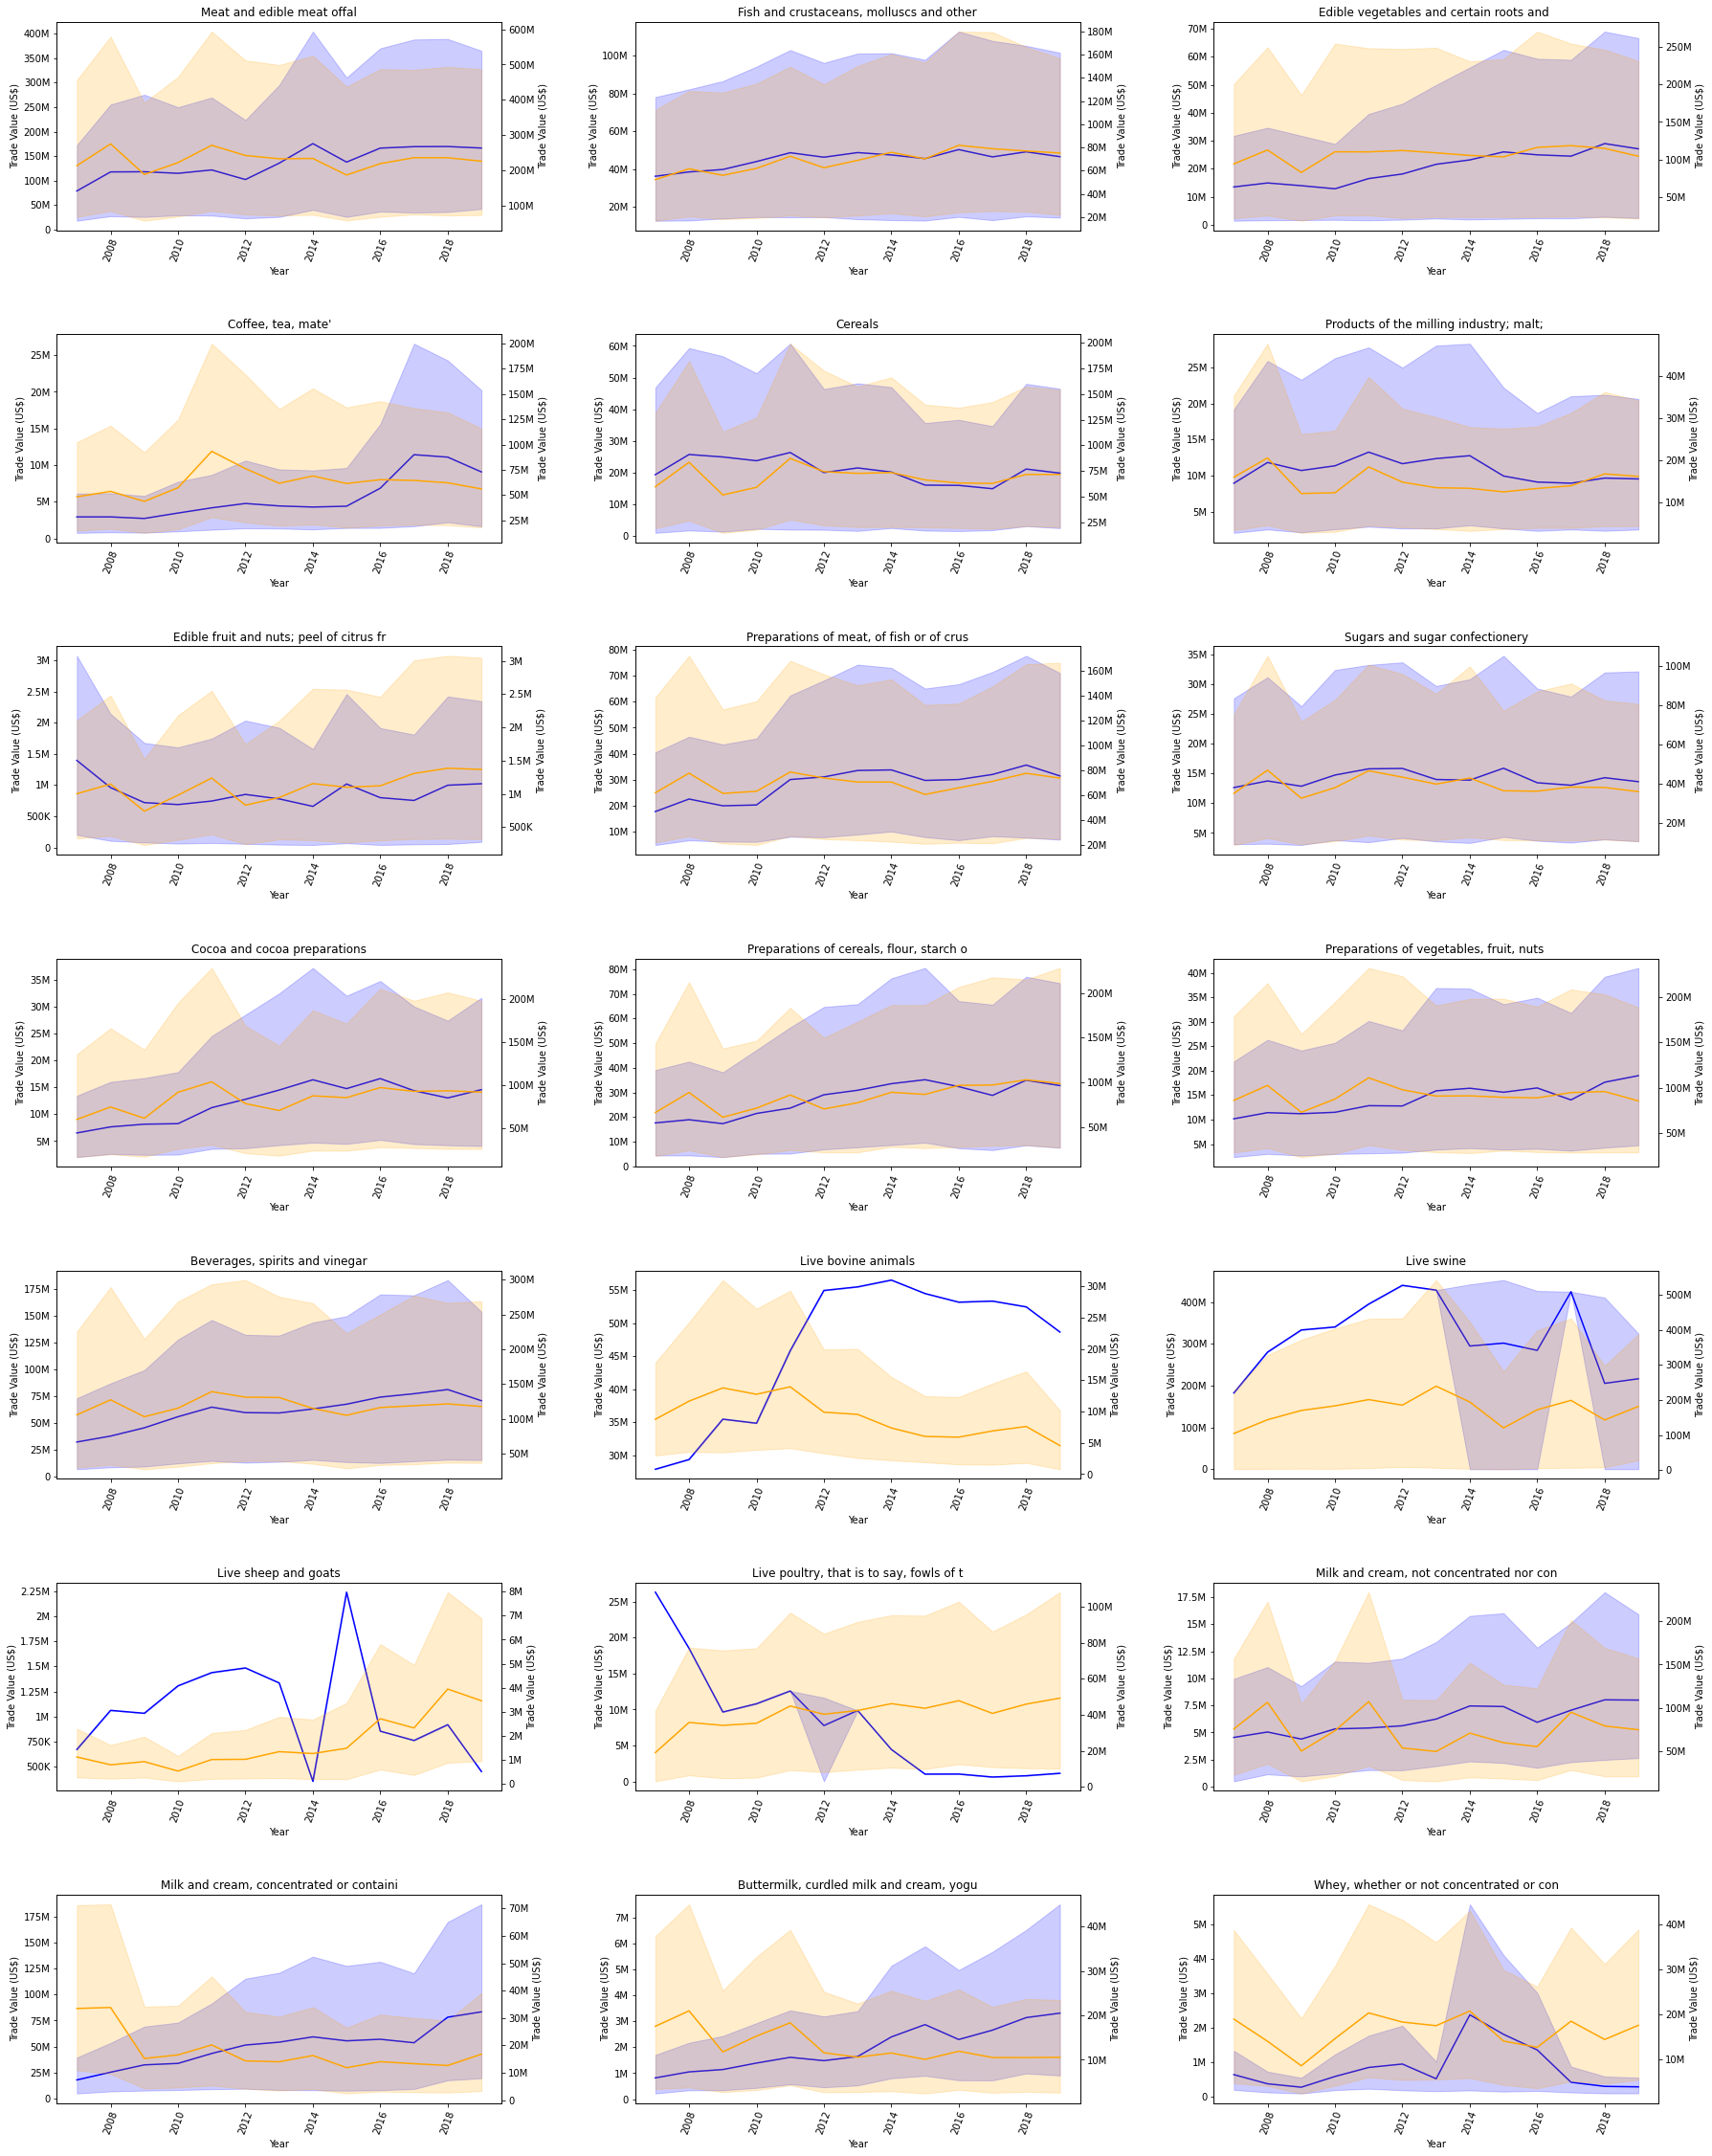

In [20]:
plot_compare_commodities_reporters("HKG", "DEU")